# Fastai 9 - collaborative filtering as a classifier
> An experiment in cross entropy loss on recsys.

- toc: true 
- badges: true
- comments: true

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     |████████████████████████████████| 720 kB 12.1 MB/s 
     |████████████████████████████████| 189 kB 49.3 MB/s 
     |████████████████████████████████| 1.2 MB 39.4 MB/s 
     |████████████████████████████████| 48 kB 816 kB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 51 kB 327 kB/s 
     |████████████████████████████████| 558 kB 32.3 MB/s 
     |████████████████████████████████| 130 kB 51.2 MB/s 
Mounted at /content/gdrive


# Experiment intro:

There is an interesting experiment on chapter 8 that suggests further research of converting the collaborative filtering model to a classification model. This post will demonstrate two different ways to convert this model using cross entropy loss.

#Download and preparing the data

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
ratings = ratings.merge(movies) #adding movie names instead of ID number

#Option 1- addjusting the loss and accuracy functions:

In [3]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [4]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [5]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, n_act=30):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 5))

        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return x

In [6]:
model = CollabNN(*embs)

loss = CrossEntropyLossFlat()
def myLoss(prediction, target):
  return loss(prediction, target-1)  

def myAccuracy(prediction, target):
  return accuracy(prediction, target-1)

learn1 = Learner(dls, model, loss_func=myLoss, metrics=myAccuracy)

Minimum/10:	1.00e-02
Steepest point:	2.75e-02
Longest valley:	6.31e-03
Slide interval:	7.59e-03


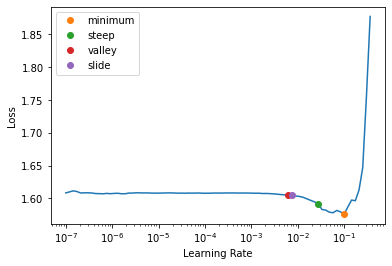

In [7]:
def lrfinder(learner):
  lr_min, lr_steep, lr_valley, lr_slide = learner.lr_find(suggest_funcs=(minimum, steep, valley, slide))
  print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")
  return 
lrfinder(learn1)

In [8]:
learn1.fit_one_cycle(5, 1.00e-02, wd=0.01)

epoch,train_loss,valid_loss,myAccuracy,time
0,1.304140,1.300469,0.413550,00:11
1,1.262539,1.272743,0.431100,00:11
2,1.222846,1.250300,0.443000,00:11
3,1.160470,1.243430,0.453700,00:11
4,1.115513,1.253342,0.449450,00:11


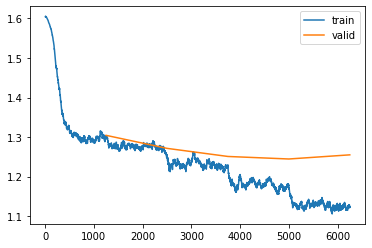

In [ ]:
learn1.recorder.plot_loss()

Why addjusting the loss and accuracy?

First trial gives the following error:

```
RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
```


Which is usualy because of some index mismatching so like you tried to train a network with 10 output nodes on a dataset with 15 labels. In this case Its better to restart the notebook, get a more accuracate traceback by moving to CPU.

With CPU we indeed recieve indexing mismatching problem:

```
IndexError: Target 5 is out of bounds.
```
Changing the last layer to 6th solve this issiue:
https://forums.fast.ai/t/getting-runtime-error-for-cross-entropy-what-should-be-changed-and-why-it-is-coming/87726/12

My preffered way is to addjust the loss and accuracy problem, the target dataset range is 1-5 as categorized (dls.vocab will give error) the loss expecting 0-n so 5 is out of bounds.


#Option 2- addjusting the dataloaders:

In [ ]:
#hide
class TabularCollab(TabularPandas):
    "Instance of `TabularPandas` suitable for collaborative filtering (with no continuous variable)"
    with_cont=False

In [17]:
cat_names = ['user', 'title']
cont_names = []

procs = [Categorify, FillMissing, Normalize]

splits = RandomSplitter()(range_of(ratings))

to1 = TabularCollab(ratings, procs, cat_names, cont_names, y_names="rating", splits=splits, y_block=CategoryBlock)

dls1 = to1.dataloaders()
dls1.show_batch()

,user,title,rating
0,109,Interview with the Vampire (1994),3
1,640,Braveheart (1995),4
2,523,Strawberry and Chocolate (Fresa y chocolate) (1993),5
3,907,Clerks (1994),4
4,933,Die Hard: With a Vengeance (1995),1
5,496,Swingers (1996),2
6,606,Mr. Holland's Opus (1995),5
7,184,Amadeus (1984),4
8,632,"Empire Strikes Back, The (1980)",5
9,70,Bram Stoker's Dracula (1992),4


In [19]:
embs = get_emb_sz(dls)

class CollabNN(Module):
    def __init__(self, user_sz, item_sz, n_act=30):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 5))

        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return x

model2 = CollabNN(*embs)

learn2 = Learner(dls1, model2, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
# learn.fit_one_cycle(5, 5e-3, wd=0.01)


Minimum/10:	4.79e-03
Steepest point:	2.29e-02
Longest valley:	1.74e-03
Slide interval:	6.31e-03


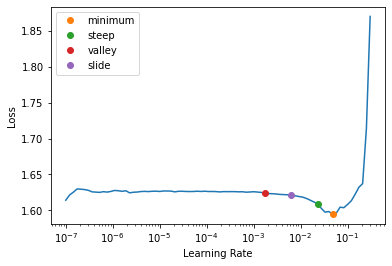

In [20]:
lrfinder(learn2)

In [21]:
learn2.fit_one_cycle(5, 1.74e-03, wd=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.272689,1.281745,0.427700,00:14
1,1.246751,1.252351,0.447700,00:11
2,1.208962,1.239627,0.447700,00:11
3,1.169290,1.240180,0.446000,00:11
4,1.145836,1.241863,0.446750,00:11


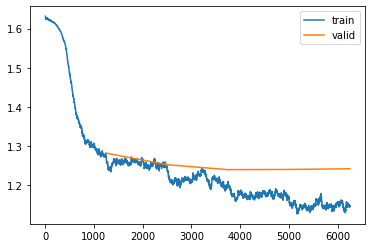

In [22]:
learn2.recorder.plot_loss()

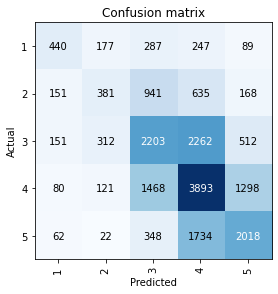

In [23]:
interp = ClassificationInterpretation.from_learner(learn2)
interp.plot_confusion_matrix()

#Summary

In this case, both models reach the same results, and the results show that using a CE loss function (or generally converting this to a classification problem) is not so good an idea, as around 45% accuracy is better than random choice, but not better than the MSE.


In [ ]:
#hide
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [ ]:
#hide
n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

In [ ]:
#hide
n_users, n_movies

(944, 1665)

In [ ]:
#hide
d = Embedding(5,3)(torch.tensor([1,1,4,4]))
r  = Embedding(5,3)(torch.tensor([1,1,4,4]))

In [ ]:
#hide
(d*r).sum(dim=1)

tensor([3.9309e-05, 3.9309e-05, 5.3709e-05, 5.3709e-05], grad_fn=<SumBackward1>)

In [ ]:
#hide
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [ ]:
#hide
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1) #wd is whight decay/ L2 regularization 

In [ ]:
#hide
# Creating Our Own Embedding Module
class T(Module):
    def __init__(self): self.a = nn.Linear(2, 3, bias=True)

t = T()
L(t.parameters())

(#2) [Parameter containing:
tensor([[ 0.6445,  0.5586],
        [-0.5054, -0.3103],
        [ 0.4772, -0.1982]], requires_grad=True),Parameter containing:
tensor([ 0.6275, -0.2450,  0.2939], requires_grad=True)]

In [ ]:
#hide
type(t.a.weight)

torch.nn.parameter.Parameter

In [ ]:
#hide
learn.model

CollabNN(
  (user_factors): Embedding(944, 74)
  (item_factors): Embedding(1665, 102)
  (layers): Sequential(
    (0): Linear(in_features=176, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [18]:
#hide
dls1.vocab

[1, 2, 3, 4, 5]

In [ ]:
#hide
dls1.one_batch()

In [ ]:
#hide
x, y = dls.one_batch()

In [ ]:
#hide
y

In [ ]:
#hide
model(x)

In [ ]:
#hide
dls1.vocab

[1, 2, 3, 4, 5]

In [ ]:
#hide
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [ ]:
#hide
dls1.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [24]:
#hide
def getxc(a):
  return [a.user, a.title]

carzy = DataBlock(blocks=(CategoryBlock, CategoryBlock, CategoryBlock), 
                  n_inp=2, 
                  get_x =  [ColReader(0), ColReader(4)],
                  # get_x = getxc, 
                  get_y = ColReader(2)
                  )

In [ ]:
#hide
carzy.summary(ratings)

In [25]:
#hide
czd = carzy.datasets(ratings)

In [26]:
#hide
czd.vocab #3 lists users, movies and scores

(#3) [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 2

In [27]:
#hide
czd.classes

AttributeError: ignored

In [28]:
#hide
czd = carzy.dataloaders(ratings)

In [30]:
#hide
czd.one_batch()

(TensorCategory([933, 647, 315, 933, 196, 591, 863, 906, 917, 291, 748, 693, 296, 466, 813, 317, 825, 589, 424, 247, 710, 105, 669, 755, 200, 717, 377, 926, 404, 600, 682, 204, 436, 762,   9, 433, 249, 406,
         384, 298, 428, 143, 117, 585, 306, 370, 641, 662, 829, 797, 255, 636, 143, 918, 404, 263, 459, 370, 880, 576, 319, 720, 458, 181], device='cuda:0'),
 TensorCategory([ 227,  833, 1189,  587,  309, 1242,  148,  515,  791, 1553, 1317, 1590,  710,  608, 1264,  547,  791,  457, 1235, 1569,  182, 1325, 1436,  566,  475, 1371,  865, 1499,  912,  705,  762,  568,
         1605, 1301,  495,  975,  675,  867, 1561, 1453,  631,  418,  881,  520, 1615,  566,  143,  460, 1532,   34, 1232, 1524,  877,  336, 1180, 1080,  875,  334,  311, 1545, 1624, 1469,  223,  547],
        device='cuda:0'),
 TensorCategory([3, 0, 4, 4, 3, 0, 3, 3, 2, 3, 3, 2, 2, 4, 3, 4, 2, 4, 2, 4, 4, 3, 3, 3, 2, 3, 3, 3, 0, 1, 3, 2, 4, 3, 4, 4, 4, 0, 2, 3, 2, 3, 3, 2, 3, 4, 3, 2, 2, 0, 4, 2, 3, 3, 0, 1, 3, 3, 2, 3, 3